## Add libraries

In [1]:
import numpy as np
import math as mt
from matplotlib.pyplot import figure
from matplotlib import pyplot as plt 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn import preprocessing
from scipy.interpolate import make_interp_spline

## Polynomial fit on training data with increasing complexity

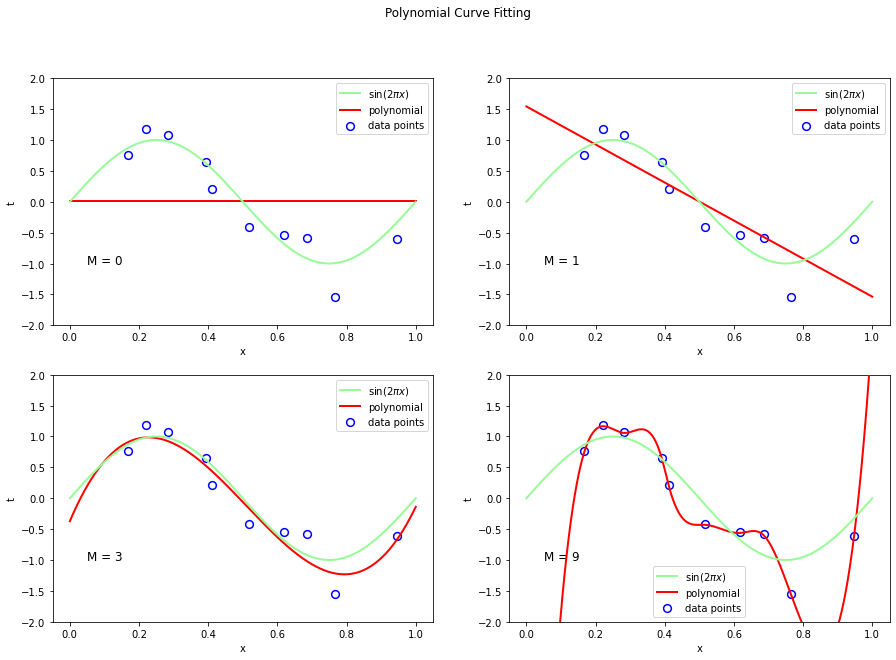

In [2]:
np.random.seed(23)

train_samples = 10
std_dev = 0.3 # std deviation for the noise
poly_complexity = [0, 1, 3, 9] # max degrees in polynomial feature transform
test_samples = 100

L = 20
M = 24 # number of basis functions
GAMMA = 300
ALPHA_PLOT = [2.6, -0.31, -2.4]
ALPHA_LIST = [np.exp(2.6), np.exp(-0.31), np.exp(-2.4)]


x = [np.random.uniform(0, 1) for _ in range(train_samples)]
x.sort()
x = np.array(x)
f = np.sin(2*mt.pi*x)
e = np.random.normal(0, std_dev, train_samples)
y = f+e

x_test_orig = [np.random.uniform(0, 1) for _ in range(test_samples)]
x_test_orig.sort()
x_test_orig = np.array(x_test_orig)

fig, axs = plt.subplots(2, 2, figsize=(15,10))
axs = axs.flatten()
for i, pc in enumerate(poly_complexity):
    poly = PolynomialFeatures(pc,include_bias=True)
    x_train = poly.fit_transform(np.reshape(x, (-1, 1)))
    x_test = poly.fit_transform(np.reshape(x_test_orig, (-1, 1)))

    # Standardize the dataset
    if pc != 0:
        scaler = preprocessing.StandardScaler().fit(x_train)
        x_train = scaler.transform(x_train)
        x_test = scaler.transform(x_test)

    reg = LinearRegression(fit_intercept=False).fit(x_train, y)
    y_test = reg.predict(x_test)
    y_train = reg.predict(x_train)
    comp = "M = "+str(pc)

    X_Y_Spline = make_interp_spline(x, y_train)
    X_ = np.linspace(0, 1, 500)
    Y_ = X_Y_Spline(X_)

    axs[i].plot(np.linspace(0, 1, 100), np.sin(2*mt.pi*np.linspace(0, 1, 100)), \
                c='palegreen', linewidth=2, label=r'$\sin (2 \pi x)$', zorder=10)
    # axs[i].plot(x_test_orig, y_test, c='r', linewidth=2, label="polynomial", zorder=5)
    axs[i].plot(X_, Y_, c='r', linewidth=2, label="polynomial", zorder=5)
    axs[i].scatter(x, y, c='white', edgecolors='blue', label="data points", \
                   linewidth=1.5, s=60, zorder=0)
    axs[i].set_xlabel("x")
    axs[i].set_ylabel("t")
    axs[i].set_ylim(-2, 2)
    axs[i].legend()
    axs[i].text(0.05, -1.0, comp, size=12)
    
plt.rcParams['figure.dpi'] = 300
plt.suptitle("Polynomial Curve Fitting")
plt.show()

## Bias Variance on Linear Models

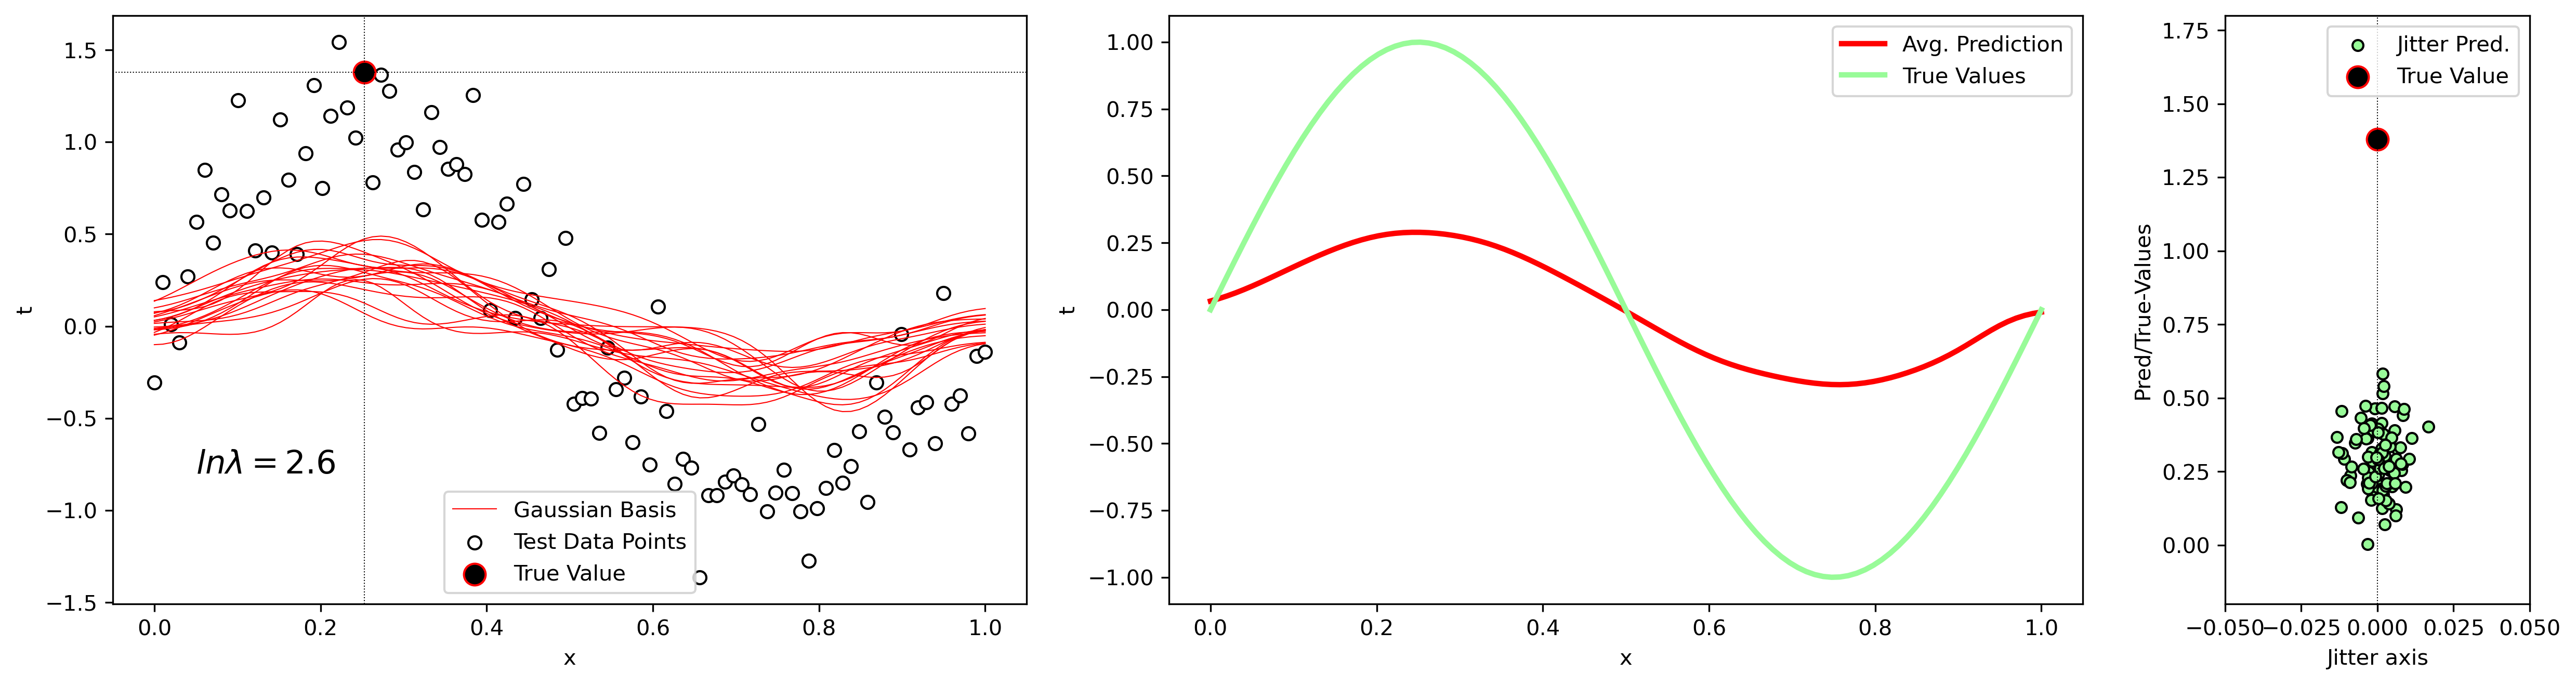

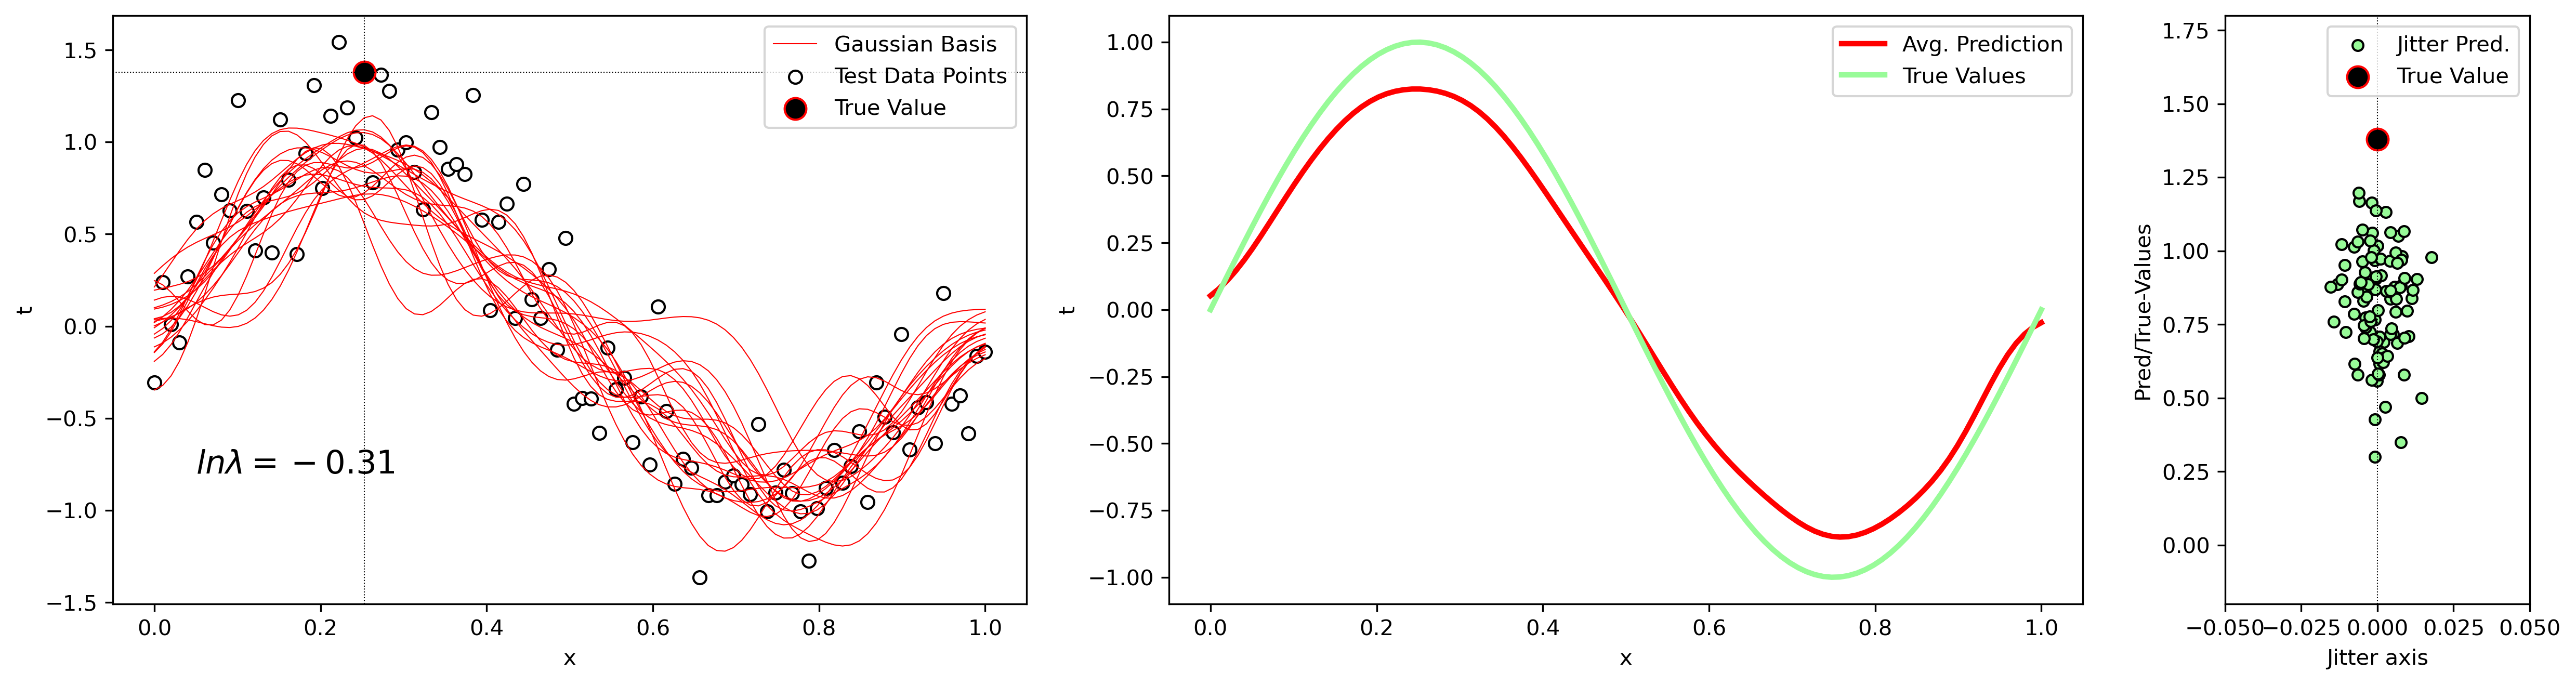

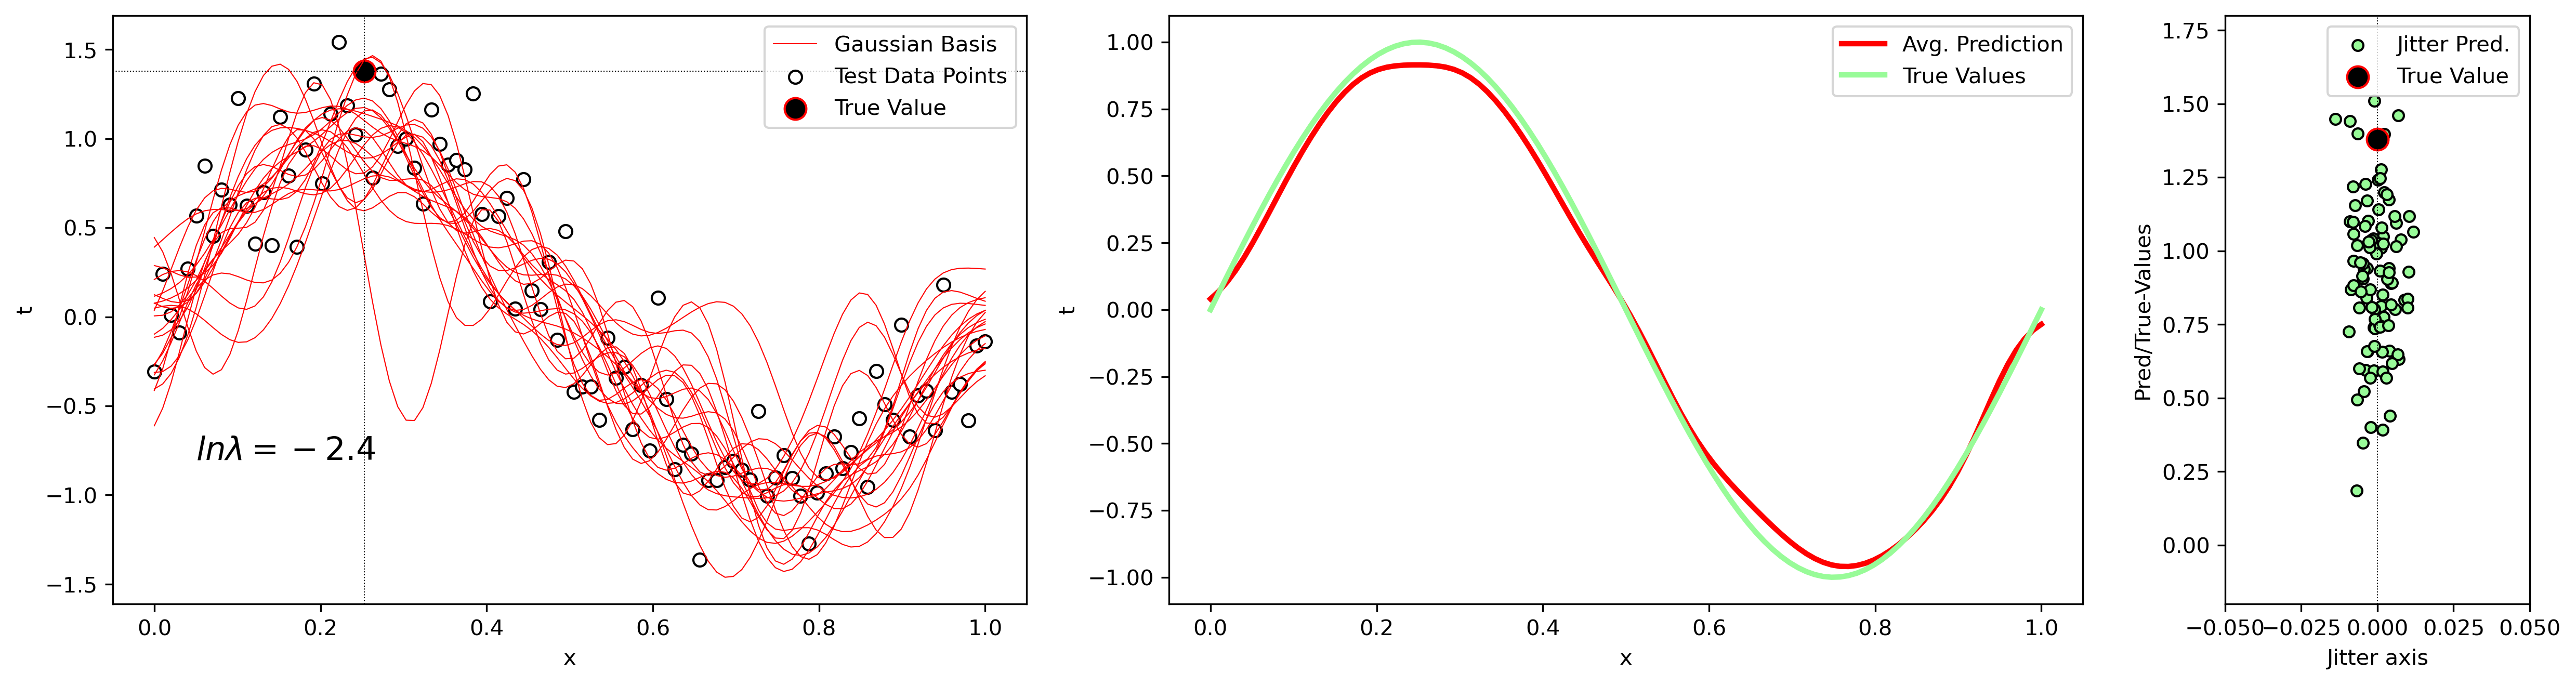

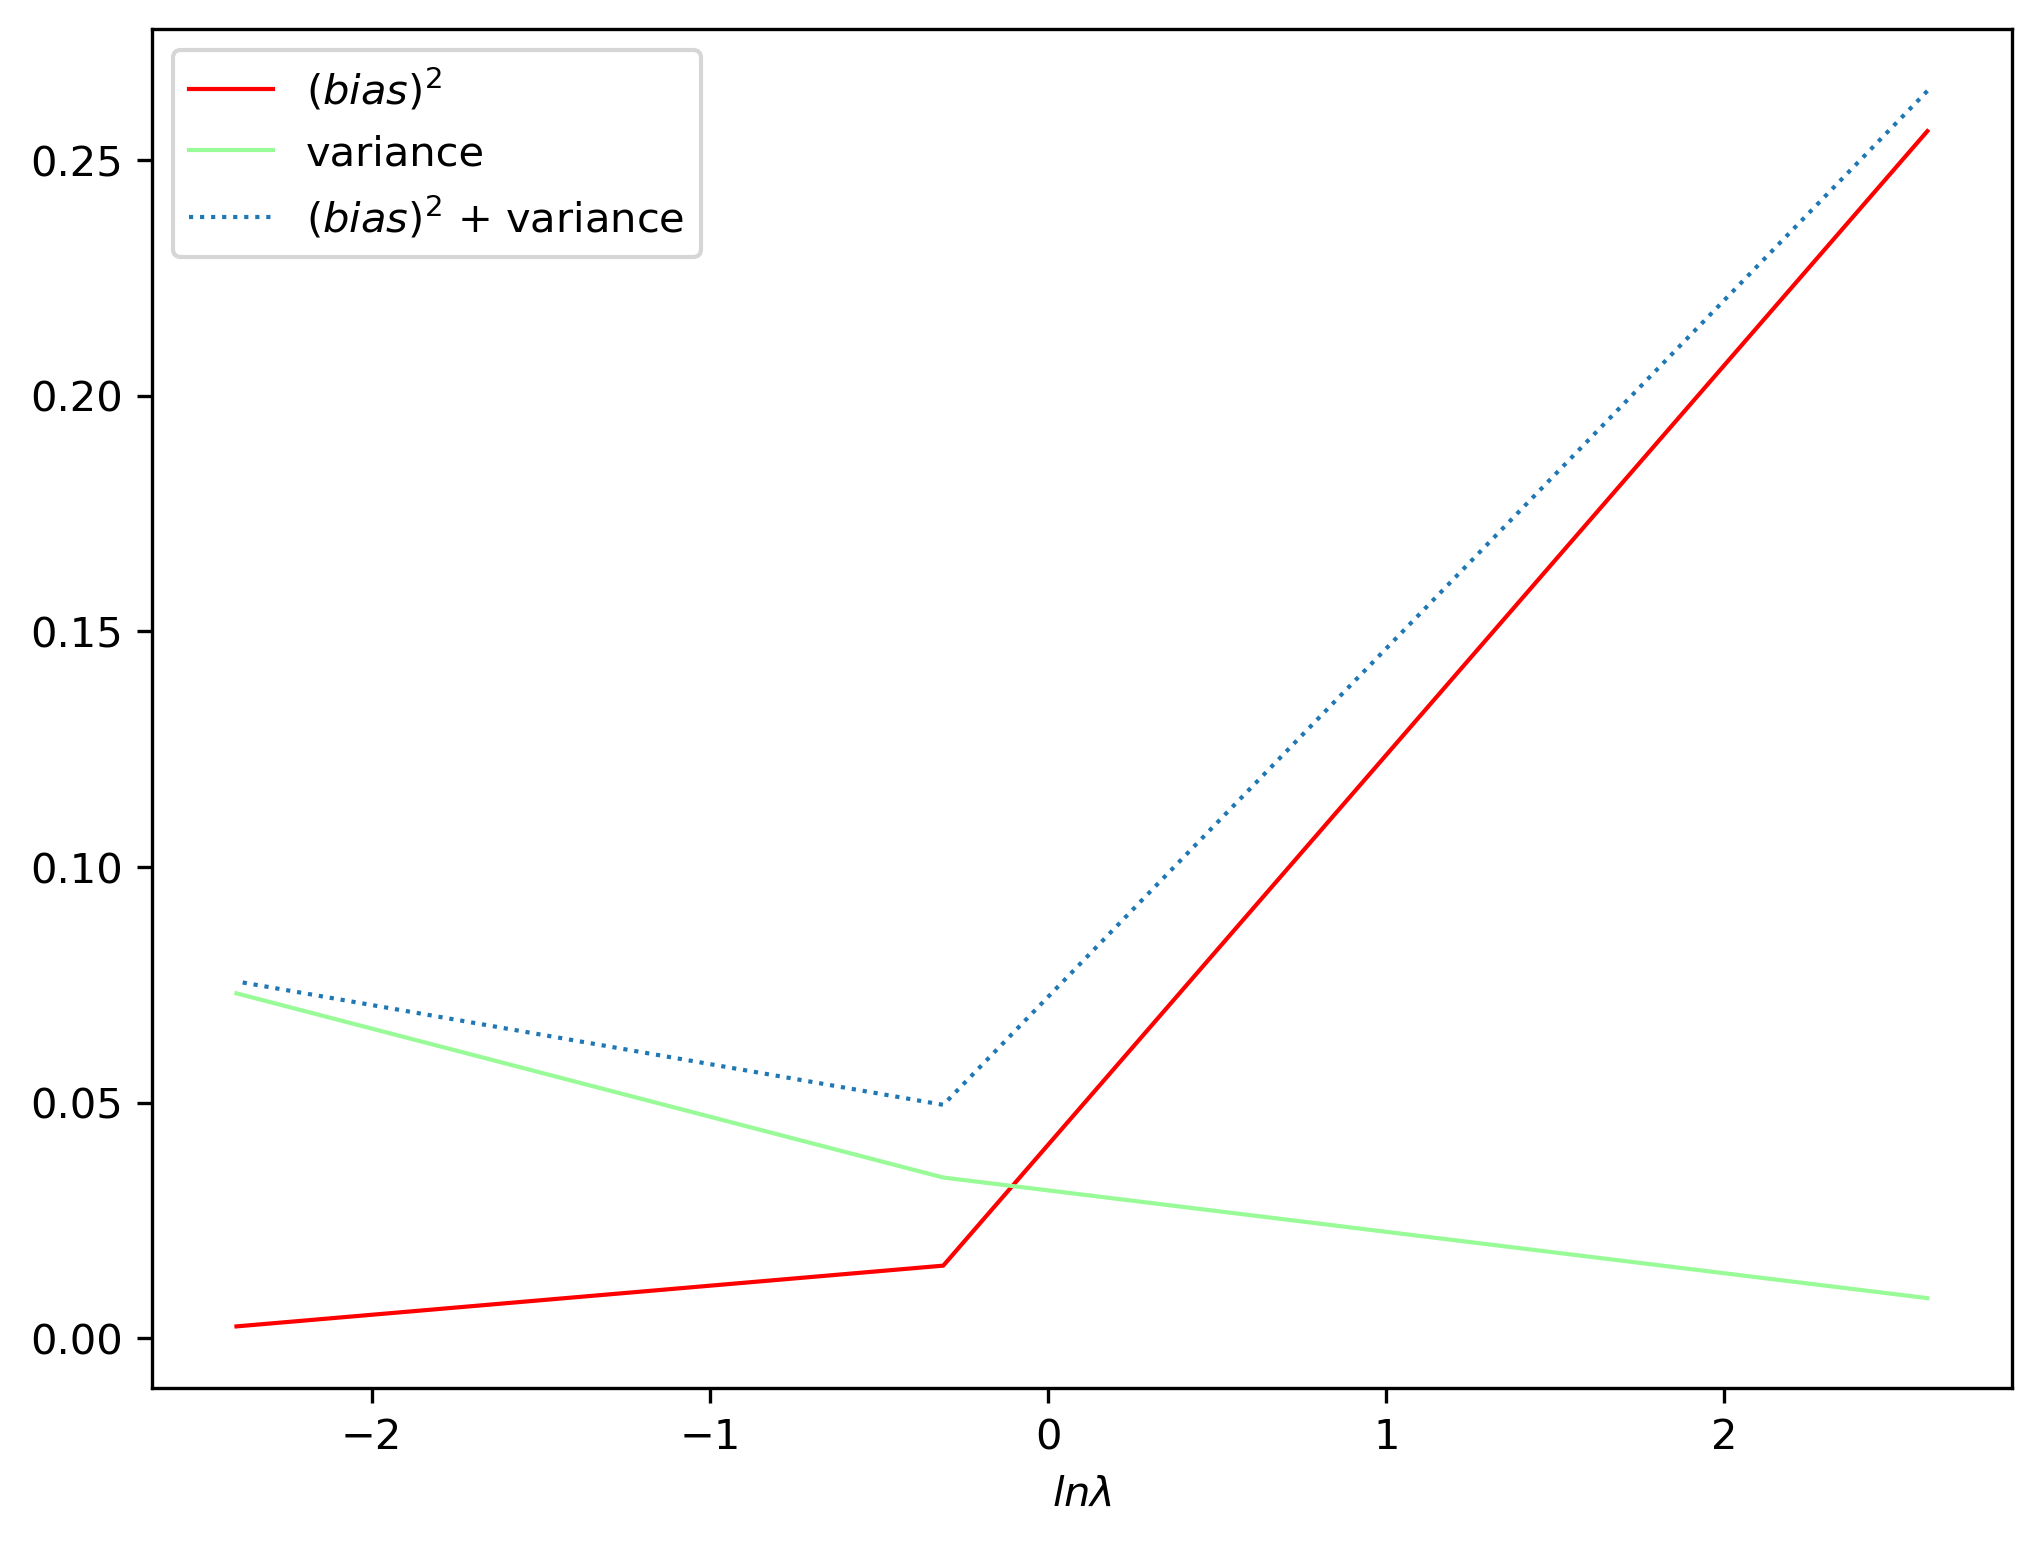

In [3]:
## References: 
## 1. https://medium.com/snu-ai/the-bias-variance-trade-off-a-mathematical-view-14ff9dfe5a3c
## 2. https://stats.stackexchange.com/questions/228561/loss-functions-for-regression-proof
## 3. https://stats.stackexchange.com/questions/623234/proof-of-the-bias-variance-decomposition-in-bishops-book
## 4. https://towardsdatascience.com/how-to-improve-your-linear-regression-with-basis-functions-and-regularization-8a6fcebdc11c
## 5. https://towardsdatascience.com/what-bias-variance-bulls-eye-diagram-really-represent-ff6fb9670993
## 6. https://towardsdatascience.com/the-bias-variance-trade-off-explained-practically-in-python-48cf29d9e900

train_samples = 25
test_samples = 100
std_dev = 0.3 # std deviation for the noise
jitter_dev = 0.006
pred_point = 25

L = 100
L_SHOW = 20
M = 24 # number of basis functions
GAMMA = 300
ALPHA_PLOT = [2.6, -0.31, -2.4]
ALPHA_LIST = [np.exp(2.6), np.exp(-0.31), np.exp(-2.4)]
# ALPHA_PLOT = np.linspace(-3, 2, num=20)
# ALPHA_LIST = np.exp(np.linspace(-3, 2, num=20))


D = []

## Generate training data set 
for _ in range(L):
    x = []
    for _ in range(train_samples):
        x.append(np.random.uniform(0, 1))
    x.sort()
    x = np.array(x)
    f = np.sin(2*mt.pi*x)
    e = np.random.normal(0, std_dev, train_samples)
    y = f+e
    D.append((x,y))

## Build features using gaussian basis
def gaussian_basis(x, mu, gamma=GAMMA):
    return np.exp(-gamma * np.linalg.norm(mu-x)**2)

# Calculate design matrix Phi
def phi(D):
    Phi = np.ones((len(D), M))
    for m in range(M-1):
        mu = m/M
        Phi[:, m+1] = np.vectorize(gaussian_basis)(D, mu)
    return Phi

## Generate the test dataset
x_test = np.linspace(0, 1, num=test_samples)
f = np.sin(2*mt.pi*x_test)
e = np.random.normal(0, std_dev, test_samples)
y_test = f+e

BIAS = []
VARIANCE = []
TEST_ERROR = []
# Iterate for each regularization 
for i in range(len(ALPHA_LIST)):
    Y_PRED = []
    ## Initiate the ridge model
    model = Ridge(alpha = ALPHA_LIST[i], fit_intercept=False)
    lam = "$ln\lambda=" + str(ALPHA_PLOT[i]) + "$"
    for k in range(L):
        model = model.fit(phi(D[k][0]), D[k][1])
        y_pred = model.predict(phi(x_test))
        Y_PRED.append(y_pred)

    mean_pred = np.mean(Y_PRED, axis=0)
    BIAS.append(sum((mean_pred-f)**2) / len(mean_pred))
    VARIANCE.append(np.sum((np.array(Y_PRED) - mean_pred)**2) / 10000)
    TEST_ERROR.append(sum((mean_pred - y_test)**2)/len(mean_pred))    
    
    ## Plot the gaussian basis
    fig, axs = plt.subplots(1, 3, figsize=(20,5), gridspec_kw={'width_ratios': [3, 3, 1]}) 

    for j in range(L_SHOW):
        if j == 0:
            axs[0].plot(x_test, Y_PRED[j], c='r', linewidth=0.5, label="Gaussian Basis")
        else:
            axs[0].plot(x_test, Y_PRED[j], c='r', linewidth=0.5)
            
    axs[0].scatter(x_test, y_test, c='white', label="Test Data Points" \
                    , edgecolors='k')
    
    axs[0].axvline(x = x_test[pred_point], color = 'k', linewidth=0.5, linestyle='dotted') 
    axs[0].axhline(y = y_test[pred_point], color = 'k', linewidth=0.5, linestyle='dotted') 
    axs[0].scatter(x_test[pred_point], y_test[pred_point], c='k', label="True Value", s=100, edgecolors='r')
    axs[0].text(0.05, -0.8, lam, size=15)
    # axs[0].set_ylim([-0.2, 1.6])
    axs[0].set_xlabel("x")
    axs[0].set_ylabel("t")
    axs[0].legend()

    axs[1].plot(x_test, mean_pred, c='r', linewidth=2.5, label="Avg. Prediction")
    axs[1].plot(x_test, f, c='palegreen', linewidth=2.5, label="True Values")
    axs[1].legend()
    # axs[1].set_ylim([-0.2, 1.6])
    axs[1].set_xlabel("x")
    axs[1].set_ylabel("t")    
    
    Y_PRED_NP=np.array(Y_PRED)
    e = np.random.normal(0, jitter_dev, L)
    
    axs[2].scatter(np.zeros(L)+e, Y_PRED_NP[:,pred_point], c='palegreen', label="Jitter Pred.", edgecolors='k', s=25)
    axs[2].scatter(0, y_test[pred_point], c='k', label="True Value", s=100, edgecolors='r')
    axs[2].axvline(x = 0, color = 'k', linewidth=0.5, linestyle='dotted')    
    axs[2].set_xlim([-0.05, 0.05])
    axs[2].set_ylim([-0.2, 1.8])
    axs[2].set_xlabel("Jitter axis")
    axs[2].set_ylabel("Pred/True-Values")      
    axs[2].legend()
    
    # plt.savefig("bias_variance_"+str(ALPHA_PLOT[i])+".png", format="png", dpi=300)

plt.rcParams['figure.dpi'] = 300
plt.show()

## Plot bias variance trade-off
lw=1
figure(figsize=(8, 6))
plt.plot(ALPHA_PLOT, BIAS, label="$(bias)^2$", linewidth=lw, c='r')
plt.plot(ALPHA_PLOT, VARIANCE, label="variance", linewidth=lw, c='palegreen')
plt.plot(ALPHA_PLOT, np.array(BIAS)+np.array(VARIANCE), label="$(bias)^2$ + variance", linestyle='dotted', linewidth=lw)
# plt.plot(ALPHA_PLOT, TEST_ERROR, label="test error", c='k', linewidth=lw)
plt.xlabel("$ln\lambda$")
plt.legend()
plt.savefig("trade_off.png", format="png", dpi=300)
plt.rcParams['figure.dpi'] = 300
plt.show()